In [13]:
import pandas as pd
import numpy as np

import random

import xgboost as xgb
import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import utils

plt.style.use('ggplot')
%matplotlib inline

import importlib
utils = importlib.reload(utils)

In [14]:
# loo = pd.read_csv('loo.csv', sep=';', header=None)
# loo.columns=['loo']
# loo['target']=y_train
# loo_loss = loo.apply(lambda x: log_loss([x['target']], [x['loo']], labels=[1, 0]), axis=1)
# pd.DataFrame(loo_loss).to_csv('loo_loss.csv', index=False, header=False, sep=';')

In [15]:
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';', na_values='None')

X_train2 = train.drop([ 'cardio'], axis=1)
X_train2 = utils.new_features(X_train2)
y_train2 = train['cardio'].values.ravel()

train = utils.clean_data(train, more_clean=True)
test = utils.clean_data(test, more_clean=True)

train = utils.new_features(train)
test = utils.new_features(test)

X_train = train.drop([ 'cardio'], axis=1)
y_train = train['cardio'].values.ravel()
X_test = test.drop([], axis=1)

idx = (X_train['ap_hi']==X_train2['ap_hi']) & (X_train['ap_lo']==X_train2['ap_lo'])
X_train2 = X_train2.loc[idx]
y_train2 = y_train2[idx]

data = pd.concat((train.drop('cardio', axis=1), test), axis=0)
dic = data.groupby('age_group_orig')['age'].mean().to_dict()
X_train['age_dif'] = X_train[['age_group_orig', 'age']].apply(lambda x: x['age'] - dic[x['age_group_orig']], axis=1)
X_test['age_dif'] = X_test[['age_group_orig', 'age']].apply(lambda x: x['age'] - dic[x['age_group_orig']], axis=1)

dic2 = data.groupby('age_group_orig')['age'].min().to_dict()
dic3 = data.groupby('age_group_orig')['age'].max().to_dict()
X_train2['age_dif2'] = X_train2[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / dic3[x['age_group_orig']], axis=1)
X_train['age_dif2'] = X_train[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / dic3[x['age_group_orig']], axis=1)
X_test['age_dif2']  =  X_test[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / dic3[x['age_group_orig']], axis=1)

# X_train['age_dif2.5'] = X_train[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / (dic3[x['age_group_orig']]-dic2[x['age_group_orig']]), axis=1)
# X_test['age_dif2.5']  =  X_test[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / (dic3[x['age_group_orig']]-dic2[x['age_group_orig']]), axis=1)

dic3 = data.groupby('age_group_orig')['age'].std().to_dict()
X_train['age_dif3'] = X_train[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / dic3[x['age_group_orig']], axis=1)
X_test['age_dif3']  =  X_test[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / dic3[x['age_group_orig']], axis=1)

train_1 = X_train['ap_lo'] < 20
train_2 = X_train['ap_hi'] < 50
train_3 = (X_train['ap_hi']<10) | (X_train['ap_lo']<20)
train_4 = (data['weight'].mean() - X_train['weight']) > (3 * data['weight'].std())
train_5 = (data['height'].mean() - X_train['height']) > (3.5 * data['height'].std())

test_1 = X_test['ap_lo'] < 20
test_2 = X_test['ap_hi'] < 50
test_3 = (X_test['ap_hi']<10) | (X_test['ap_lo']<20)
test_4 = (data['weight'].mean() - X_test['weight']) > (3 * data['weight'].std())
test_5 = (data['height'].mean() - X_test['height']) > (3.5 * data['height'].std())

D:\Projects\ML Bootcamp V\utils.py:278: RuntimeWarning: invalid value encountered in log
  data['%s_mul_log_%s' % (col1, col2)] = data[col1] * np.log(data[col2] + 1)
D:\Projects\ML Bootcamp V\utils.py:279: RuntimeWarning: invalid value encountered in log
  data['%s_div_log_%s' % (col1, col2)] = data[col1] / (np.log(data[col2] + 1) + 1)
D:\Projects\ML Bootcamp V\utils.py:275: RuntimeWarning: invalid value encountered in log
  data[col1 + '_log'] = np.log(data[col1] + 1.1)


In [16]:
loo_loss = pd.read_csv('loo_loss.csv', sep=';', header=None)
strat = pd.qcut(loo_loss, 20, labels=False).astype(str)
strat = np.hstack((strat, y_train.reshape((-1,1))))
strat =np.apply_along_axis(lambda d: str(d[0]) + '_' + str(d[1]), 1, strat)

In [17]:
use_columns = [
"gender",
"height",
"weight",
"ap_hi",
"ap_lo",
"cholesterol",
"active_fair",
"smoke_restored",
"alco_restored",
"height_mul_log_gluc",
"BMI",
"age_group",
"cholesterol_div_log_gluc",
"gluc_mul_log_age",
'age_dif2',
'ap_lo_mul_log_ap_hi',

'ap_hi_1',
'ap_lo_1',
'ap_hi_2',
'ap_lo_2',
]
model_name = '+-XGB_1.5_hey3'
params = {
     'colsample_bytree': 0.875,
     'gamma': 0.05,
     'learning_rate': 0.02,
     'max_depth': 5,
     'min_child_weight': 5,
     'n_estimators': 369,
    #'scale_pos_weight': 1.0008,

     'reg_alpha': 0,
     'reg_lambda': 10,
     'subsample': 0.7,
    
    'n_jobs': -1,
    'random_state': 1223,
    'silent': True,
}
model = xgb.XGBClassifier(**params)
utils.execute_model(model,
              X_train[use_columns],
              y_train,
              X_test[use_columns],
              model_name=model_name,
              n_splits=0,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()

# 10 folds logloss:
# [0.53731990653713735, 0.5371451460103317, 0.53759305584367933, 0.53649916905123263, 0.5365669149833473, 0.53913942057634634, 0.53802636138177329, 0.53734196102539478, 0.53772344060100696, 0.53709262123337387]
# mean: 0.537444799724 7387 7372 7383 7381 7355 7363 7404

# 7329
# std: 0.000722112840278

# 10 folds logloss:
# [0.53720594199248062, 0.53716094613136289, 0.53745255427640426, 0.53646455688914996, 0.53638906534470165, 0.53910949466140901, 0.53780741584711, 0.53729266758176475, 0.53769007558631587, 0.53695613165250577]
# mean: 0.537352884996
# std: 0.000731673051514
# +-XGB_1.5_hey2 results saved!


10 folds logloss:
[0.53683087878243174, 0.53739440015392026, 0.53703107500107594, 0.53629097760746192, 0.53612553688910203, 0.53915086945768242, 0.53804198434940032, 0.53659263486673847, 0.53763225976905393, 0.53643972637262194]
mean: 0.537153034325
std: 0.000883736311121
+-XGB_1.5_hey3 results saved!


63

In [18]:
use_columns = [
# "gender",
# "height",
# "weight",
# "ap_hi",
# "ap_lo",
# "cholesterol",
# "active_fair",
# "smoke_restored",
# "alco_restored",
# "height_mul_log_gluc",
# "BMI",
# "age_group",
# "cholesterol_div_log_gluc",
# "gluc_mul_log_age",
# 'age_dif2',
# 'ap_lo_mul_log_ap_hi'
    
#     "gender",
# "ap_hi",
# "ap_lo",
# "cholesterol",
# "active_fair",
# "smoke_restored",
# "alco_restored",
# "height_mul_log_cholesterol",
# "height_mul_log_gluc",
# "BMI",
# "age_group",
# "cholesterol_div_log_gluc",
# "gluc_mul_log_age",
# "ap_hi_mul_weight",
# "age_dif2",
# 'ap_lo_mul_log_ap_hi',
# 'age_group_div_height',
# 'age_group_mul_log_MAP'
    
    'gender',
'ap_hi',
'ap_lo',
'cholesterol',
'active_fair',
'smoke_restored',
'alco_restored',
'height_mul_log_cholesterol',
'height_mul_log_gluc',
'BMI',
'age_group',
'cholesterol_div_log_gluc',
'gluc_mul_log_age',
'age_dif2',
'ap_lo_mul_log_ap_hi',
'age_group_div_height',
'age_group_mul_log_MAP',
'cholesterol_div_ap_hi',
'ap_hi_mul_log_gluc',
'BMI_div_ap_hi',
'BMI_div_log_age',
# 'gluc',
'gluc_mul_height',

'ap_hi_1',
'ap_lo_1',
'ap_hi_2',
'ap_lo_2',
]
model_name = '+-XGB_hist_last_hey3'
params = {
     'colsample_bytree': 0.95,
     'gamma': 0.55,
     'learning_rate': 0.02,
     'max_depth': 5,
     'min_child_weight': 3,
     'n_estimators': 392,
     'reg_alpha': 0,
     'reg_lambda': 0.4,
     'subsample': 0.85,
    
    #'scale_pos_weight': 1.0008,

    'tree_method': 'hist',
    'grow_policy': 'lossguide',
    
    'n_jobs': 4,
    'random_state': 2222,
    'silent': True,
}
utils.execute_model(xgb.XGBClassifier(**params),
              X_train[use_columns],
              y_train,
              X_test[use_columns],
              model_name=model_name,
              n_splits=0,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()
# 10 folds logloss:
# [0.53757190997207693, 0.5380473325125551, 0.53740657876655074, 0.53637490868959747, 0.53654954023473578, 0.53888017941311606, 0.53783108141170444, 0.53687143028967788, 0.53758322567055628, 0.53653519701878949]
# mean: 0.537365138398
# std: 0.000751543774796

# 10 folds logloss:
# [0.53652502003303926, 0.53822653738835646, 0.53701765458617179, 0.53608297558267504, 0.53673609970384017, 0.53826651063431563, 0.53853680535003579, 0.53728310895360654, 0.53718299642914946, 0.53730986089232202]
# mean: 0.537316756955
# std: 0.000762431052301


10 folds logloss:
[0.5361988439327745, 0.53878553475211877, 0.53642550825857205, 0.53594055637981564, 0.5361002982727765, 0.5379512786791748, 0.53839335070994565, 0.53687083555218573, 0.53820052226766257, 0.53704927838189853]
mean: 0.537191600719
std: 0.00100157499167
+-XGB_hist_last_hey3 results saved!


91

In [19]:
use_columns = [
"gender",
"height",
"weight",
"ap_hi",
"ap_lo",
"cholesterol",
"height_div_ap_lo",
"active_fair",
"smoke_restored",
"alco_restored",
"height_mul_log_cholesterol",
"height_mul_log_gluc",
"BMI",
"age_group",
"cholesterol_div_log_gluc",
"gluc_mul_log_age",
"ap_hi_mul_weight",

'ap_hi_1',
'ap_lo_1',
'ap_hi_2',
'ap_lo_2',
]

model_name = '+-XGB_5++_hey3'
params = {
     'colsample_bytree': 0.875,
     'gamma': 0.05,
     'learning_rate': 0.02,
     'max_depth': 5,
     'min_child_weight': 5,
     'n_estimators': 369,
    #'scale_pos_weight': 1.0008,

     'reg_alpha': 0,
     'reg_lambda': 10,
     'subsample': 0.7,
    
    'n_jobs': -1,
    'random_state': 5555,
    'silent': True,
}
utils.execute_model(xgb.XGBClassifier(**params),
              X_train[use_columns],
              y_train,
              X_test[use_columns],
              model_name=model_name,
              n_splits=0,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()


10 folds logloss:
[0.53679096203406984, 0.53686247819084321, 0.53722622819229526, 0.53670143130906356, 0.53668676167029405, 0.5388207351446832, 0.53853416463088055, 0.53751440324474176, 0.53710882082165756, 0.53709345427608357]
mean: 0.537333943951
std: 0.000716923158664
+-XGB_5++_hey3 results saved!


42

In [20]:
use_columns = [
"gender",
"ap_hi",
"ap_lo",
"cholesterol",
"active_fair",
"smoke_restored",
"alco_restored",
"height_mul_log_cholesterol",
"height_mul_log_gluc",
"BMI",
"age_group",
"cholesterol_div_log_gluc",
"gluc_mul_log_age",
"ap_hi_mul_weight",
"age_dif2",
'ap_lo_mul_log_ap_hi',
'age_group_div_height',
'age_group_mul_log_MAP',

'ap_hi_1',
'ap_lo_1',
'ap_hi_2',
'ap_lo_2',
]
model_name = '+-XGB_11.5_hey3'
params = {
     'colsample_bytree': 0.875,
     'gamma': 0.05,
     'learning_rate': 0.02,
     'max_depth': 5,
     'min_child_weight': 5,
     'n_estimators': 369,
    
    #'scale_pos_weight': 1.0008,

     'reg_alpha': 0,
     'reg_lambda': 10,
     'subsample': 0.7,
    
    'n_jobs': -1,
    'random_state': 1223,
    'silent': True,
}
utils.execute_model(xgb.XGBClassifier(**params),
              X_train[use_columns],
              y_train,
              X_test[use_columns],
              model_name=model_name,
              n_splits=0,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()


10 folds logloss:
[0.53655731619564451, 0.53760840705419, 0.53614940550827284, 0.53577996441323572, 0.53642402483270102, 0.53844697005811515, 0.53818211341601374, 0.53721983370543724, 0.53748259387352615, 0.53680509493777651]
mean: 0.537065572399
std: 0.000829288977356
+-XGB_11.5_hey3 results saved!


91

In [21]:
use_columns = [
'gender',
'height',
'weight',
'ap_hi',
'ap_lo',
'cholesterol',
'active_fair',
'smoke_restored',
'alco_restored',
'height_mul_log_cholesterol',
'height_mul_log_gluc',
'BMI',
'age_group',
'cholesterol_div_log_gluc',
'gluc_mul_log_age',
'ap_hi_mul_weight',
'age_dif',
'ap_lo_mul_log_ap_hi',
'age_group_div_height',
'age_group_mul_log_MAP',

'ap_hi_1',
'ap_lo_1',
'ap_hi_2',
'ap_lo_2',
]
model_name = '+-XGB_10++_hey3'
params = {
     'colsample_bytree': 0.875,
     'gamma': 0.05,
     'learning_rate': 0.02,
     'max_depth': 5,
     'min_child_weight': 5,
     'n_estimators': 369,
    
    #'scale_pos_weight': 1.0008,

     'reg_alpha': 0,
     'reg_lambda': 10,
     'subsample': 0.7,
    
    'n_jobs': -1,
    'random_state': 1223,
    'silent': True,
}
utils.execute_model(xgb.XGBClassifier(**params),
              X_train[use_columns],
              y_train,
              X_test[use_columns],
              model_name=model_name,
              n_splits=0,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()


10 folds logloss:
[0.5364698861017192, 0.53781121748786065, 0.53598726343594916, 0.53576783617738977, 0.5361966183906417, 0.53908515516418154, 0.53816753472292644, 0.5373156112660652, 0.5373011023033224, 0.53701224415847271]
mean: 0.537111446921
std: 0.000995269200566
+-XGB_10++_hey3 results saved!


91

In [22]:
use_columns = [
'gender',
'ap_hi',
'ap_lo',
'cholesterol',
'active_fair',
'smoke_restored',
'alco_restored',
'height_mul_log_cholesterol',
'height_mul_log_gluc',
'BMI',
'age_group',
'cholesterol_div_log_gluc',
'gluc_mul_log_age',
'age_dif2',
'ap_lo_mul_log_ap_hi',
'age_group_div_height',
'age_group_mul_log_MAP',
'cholesterol_div_ap_hi',
'ap_hi_mul_log_gluc',
'BMI_div_ap_hi',
'BMI_div_log_age',
# 'gluc',
'gluc_mul_height',

# 'cholesterol_div_weight',
# 'ap_hi_div_ap_lo',
# 'height_mul_log_ap_hi',
# 'BMI_div_cholesterol',
# 'cholesterol_div_log_ap_lo',
#     'BMI_1',
#     'age_group_div_log_gluc',

'ap_hi_1',
'ap_lo_1',
'ap_hi_2',
'ap_lo_2',
]
model_name = '+-XGB_15_hey3'
params = {
     'colsample_bytree': 0.875,
     'gamma': 0.05,
     'learning_rate': 0.02,
     'max_depth': 5,
     'min_child_weight': 5,
     'n_estimators': 369,
    'scale_pos_weight': 1.0008,

     'reg_alpha': 0,
     'reg_lambda': 10,
     'subsample': 0.7,
    
    'n_jobs': -1,
    'random_state': 1223,
    'silent': True,
}
utils.execute_model(xgb.XGBClassifier(**params),
              X_train[use_columns],
              y_train,
              X_test[use_columns],
              model_name=model_name,
              n_splits=0,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()
# 10 folds logloss:
# [0.53646016616605852, 0.53819110210055832, 0.53700349915524548, 0.53586434324496812, 0.53614972118656656, 0.53817725547795814, 0.537725036665749, 0.53720775463564263, 0.53785448705315742, 0.53667016882603535]
# mean: 0.537130353451
# std: 0.000796657672578

# 10 folds logloss:
# [0.53646141939657832, 0.53815644988699762, 0.53697043853302318, 0.53582988165501011, 0.536220359169709, 0.53827735193706205, 0.537880909573071, 0.53717420261473092, 0.5379235707759743, 0.53683144369524272]
# mean: 0.537172602724
# std: 0.000814050947736


# mean: 0.537159955619


10 folds logloss:
[0.53596526252239507, 0.53823302068030665, 0.53646238367329391, 0.53593721320599252, 0.53619144349757808, 0.53841573595073788, 0.53796983128802267, 0.53701953978689065, 0.53731145101300326, 0.53723424287518617]
mean: 0.537074012449
std: 0.000877820493706
+-XGB_15_hey3 results saved!


91

In [27]:
use_columns = [
'gender',
'ap_hi',
'ap_lo',
'cholesterol',
'active_fair',
'smoke_restored',
'alco_restored',
'height_mul_log_cholesterol',
'height_mul_log_gluc',
'BMI',
'age_group',
'cholesterol_div_log_gluc',
'gluc_mul_log_age',
'age_dif2',
'ap_lo_mul_log_ap_hi',
'age_group_div_height',
'age_group_mul_log_MAP',
'cholesterol_div_ap_hi',
'ap_hi_mul_log_gluc',
'BMI_div_ap_hi',
'BMI_div_log_age',
# 'gluc',
'gluc_mul_height',

# 'cholesterol_div_weight',
# 'ap_hi_div_ap_lo',
# 'height_mul_log_ap_hi',
# 'BMI_div_cholesterol',
# 'cholesterol_div_log_ap_lo',
#     'MAP_div_ap_lo',
#     'ap_dif',
#     'BMI_3'

'ap_hi_1',
'ap_lo_1',
'ap_hi_2',
'ap_lo_2',
]
model_name = 'XGB_16_hey2'
params = {
     'colsample_bytree': 0.875,
     'gamma': 0.05,
     'learning_rate': 0.02,
     'max_depth': 5,
     'min_child_weight': 5,
     'n_estimators': 369,
    #'scale_pos_weight': 1.0008,

     'reg_alpha': 0,
     'reg_lambda': 10,
     'subsample': 0.7,
    
    'n_jobs': -1,
    'random_state': 1223,
    'silent': True,
}

X1 = X_train[use_columns].copy()
X2 = X_test[use_columns].copy()

from itertools import combinations
from patsylearn import PatsyModel, PatsyTransformer

interactions = []
for i in range(2, 5):
    for comb in combinations(['alco_restored', 'smoke_restored', 'active_restored', 'age_group', 'gender', 'gluc', 'cholesterol'], i):
        interactions.append(':'.join(['C(%s)' % c for c in comb]))
formula = ' + '.join(interactions)
transformer = PatsyTransformer(formula)
transformer.fit(data)
X1 = pd.concat((X1, pd.DataFrame(transformer.transform(X_train))), axis=1)
X2 = pd.concat((X2, pd.DataFrame(transformer.transform(X_test))), axis=1)
# for m in ['XGB_10',
#  'XGB_10+',
#  'XGB_12+',
#  'XGB_13+',
#  'XGB_14',
#  'XGB_1_new2',
#  'XGB_1_new3+',
#  'XGB_2hist_new',
#  'XGB_5',
#  'XGB_5+']:

#     tr_pr, ts_pr, _, _ = utils.load_model(m)
#     X1[m] = tr_pr
#     X2[m] = ts_pr
utils.execute_model(xgb.XGBClassifier(**params),
              X1,
              y_train,
              X2,
              model_name=model_name,
              n_splits=0,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()


10 folds logloss:
[0.53584379411531313, 0.5379204437885805, 0.53685329615344046, 0.53593173720193965, 0.53589469605506002, 0.53835195593721119, 0.53813142447067774, 0.53708889733699383, 0.53744152613702623, 0.53700221169126938]
mean: 0.537045998289
std: 0.00088645551337
XGB_16_hey2 results saved!


85393

In [23]:
model_name = 'LGB_1_hey3'
params = {
    'colsample_bytree': 0.7,
     'learning_rate': 0.01,
     'min_child_weight': 4,
     'n_estimators': 666,
     'num_leaves': 32,
     'reg_alpha': 0.7,
     'reg_lambda': 1.0,
     'subsample': 0.9,
       
    'nthread': 4,
    'seed': 8718,
    'silent': True,
}
use_columns = [
'gender',
'ap_hi',
'ap_lo',
'cholesterol',
'active_fair',
'smoke_restored',
'alco_restored',
'height_mul_log_cholesterol',
'height_mul_log_gluc',
'BMI',
'age_group',
'cholesterol_div_log_gluc',
'gluc_mul_log_age',
'age_dif2',
'ap_lo_mul_log_ap_hi',
'age_group_div_height',
'age_group_mul_log_MAP',
'cholesterol_div_ap_hi',
'ap_hi_mul_log_gluc',
'BMI_div_ap_hi',
'BMI_div_log_age',
'gluc_mul_height',

'ap_hi_1',
'ap_lo_1',
'ap_hi_2',
'ap_lo_2',
]
utils.execute_model(lgb.LGBMClassifier(**params),
              X_train[use_columns],
              y_train,
              X_test[use_columns],
              model_name=model_name,
              n_splits=0,
              n_folds=10,
              stratification_groups=strat,
             )
gc.collect()
# 10 folds logloss:
# [0.53646016616605852, 0.53819110210055832, 0.53700349915524548, 0.53586434324496812, 0.53614972118656656, 0.53817725547795814, 0.537725036665749, 0.53720775463564263, 0.53785448705315742, 0.53667016882603535]
# mean: 0.537130353451
# std: 0.000796657672578


10 folds logloss:
[0.53631608386790208, 0.53851990718522869, 0.5371012506286349, 0.53594555272149536, 0.53668218559150793, 0.5390138497872593, 0.53809440288195709, 0.53716750180731143, 0.53802401725600102, 0.53689507240231138]
mean: 0.537375982413
std: 0.000944898659146
LGB_1_hey3 results saved!


138

# KERAS models

In [24]:
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adamax
import pandas as pd


class KerasModel(object):
    def __init__(self,
                 var_num,
                 epochs=70,
                 learn_rate=0.1,
                 config=None,
                 batch_size=512,
                 verbose=0,
                 validation_split=0.2,
                 loss="binary_crossentropy"):

        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.validation_split = validation_split
        
        self.model = Sequential()
        model = self.model
        
        if config is None:
            config =[(var_num, 0.0)]
        else:
            config = config.copy()
            
        n, dp = config.pop(0)

        model.add(Dense(n, input_dim=var_num, kernel_initializer='uniform'))
        model.add(LeakyReLU())
        if 0 < dp < 1:
            model.add(Dropout(dp))
        
        while config:
            n, dp = config.pop(0)
            model.add(Dense(n, kernel_initializer='uniform'))
            model.add(LeakyReLU())
            if 0 < dp < 1:
                model.add(Dropout(dp))


        model.add(Dense(1, activation='sigmoid'))
        opt = Adamax(lr=learn_rate)

        model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])


    def fit(self, X, y, sample_weight=None, callbacks=[]):
        process_X = X.values if hasattr(X, 'iloc') else X
        process_y = y
        return self.model.fit(process_X, process_y, batch_size=self.batch_size,
                       epochs=self.epochs, verbose=self.verbose,
                       sample_weight=sample_weight,
                       callbacks=callbacks,
                       validation_split=self.validation_split,
                       shuffle=True)

    def predict_proba(self, X):
        process_x = X.values if hasattr(X, 'iloc') else X
        result  = self.model.predict(process_x)
        classone_probs = result
        classzero_probs = 1.0 - classone_probs
        return np.hstack((classzero_probs, classone_probs))
#         return result
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

Using Theano backend.


In [14]:
use_columns = [
'gender',
'height',
'weight',
'ap_hi',
'ap_lo',
'cholesterol',
'active_restored',
'smoke_restored',
'alco_restored',
'height_mul_log_cholesterol',
'height_mul_log_gluc',
'BMI',
# 'age_group',
'cholesterol_div_log_gluc',
'gluc_mul_log_age',
'ap_hi_mul_weight',
'age_dif2',
'ap_lo_mul_log_ap_hi',
'age_group_div_height',
'age_group_mul_log_MAP',

'ap_hi_1',
'ap_lo_1',
'ap_hi_2',
'ap_lo_2',
]

X1 = X_train[use_columns]
X2 = X_test[use_columns]

X = pd.concat((X1,X2), axis=0)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = StandardScaler().fit(X)
X1 = pd.DataFrame(scaler.transform(X1)) #.values
X2 = pd.DataFrame(scaler.transform(X2)) #.values

def create(x1, x2):
    config = [(64,0.075), (64,0.025)]
    return KerasModel(var_num=len(use_columns),
                   epochs=200,
                   learn_rate=0.001,
                   config=config,
                   batch_size=1024,
                   verbose=0,
                   validation_split=0.0)
utils.execute_model(None,
              X1,
              y_train,
              X2,
              model_name="+-KERAS_3_hey3",
              n_splits=0,
              n_folds=10,
              stratification_groups=strat,
              create_callback=create
             )


10 folds logloss:
[0.53919093926065131, 0.53980989007171887, 0.54064485447017407, 0.53891908919910125, 0.53750032918880297, 0.5407593278956413, 0.53828767919510767, 0.53871945788254894, 0.53946882582298639, 0.53981705894254561]
mean: 0.539311745193
std: 0.000961787753359
+-KERAS_3_hey2 results saved!


(0.53931174519292768, None)

In [25]:
use_columns = [
'gender',
'ap_hi',
'ap_lo',
'cholesterol',
'active_restored',
'smoke_restored',
'alco_restored',
'height_mul_log_cholesterol',
'height_mul_log_gluc',
'BMI',
'age_group',
'cholesterol_div_log_gluc',
'gluc_mul_log_age',
'age_dif2',
'ap_lo_mul_log_ap_hi',
'age_group_div_height',
'age_group_mul_log_MAP',
'cholesterol_div_ap_hi',
'ap_hi_mul_log_gluc',
'BMI_div_ap_hi',
'BMI_div_log_age',
# 'gluc',
'gluc_mul_height',

'ap_hi_1',
'ap_lo_1',
'ap_hi_2',
'ap_lo_2',
]

X1 = X_train[use_columns]
X2 = X_test[use_columns]

X = pd.concat((X1,X2), axis=0)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = StandardScaler().fit(X)
X1 = pd.DataFrame(scaler.transform(X1)) #.values
X2 = pd.DataFrame(scaler.transform(X2)) #.values

def create(x1, x2):
    config = [(64,0.075), (64,0.025)]
    return KerasModel(var_num=len(use_columns),
                   epochs=200,
                   learn_rate=0.001,
                   config=config,
                   batch_size=1024,
                   verbose=0,
                   validation_split=0.0)
utils.execute_model(None,
              X1,
              y_train,
              X2,
              model_name="+-KERAS_4_hey3",
              n_splits=0,
              n_folds=10,
              stratification_groups=strat,
              create_callback=create
             )


10 folds logloss:
[0.53808503548482933, 0.53884686765635181, 0.54003997763976341, 0.53812692408851048, 0.53751825536679487, 0.53995355279650969, 0.53869798183479278, 0.53713969671228812, 0.53888532399449207, 0.53918895585501081]
mean: 0.538648257143
std: 0.000904036643709
+-KERAS_4_hey3 results saved!


(0.53864825714293429, None)

In [26]:
use_columns = [
'gender',
'ap_hi',
'ap_lo',
'cholesterol',
'active_restored',
'smoke_restored',
'alco_restored',
'height_mul_log_cholesterol',
'height_mul_log_gluc',
'BMI',
'age_group',
'cholesterol_div_log_gluc',
'gluc_mul_log_age',
'age_dif2',
'ap_lo_mul_log_ap_hi',
'age_group_div_height',
'age_group_mul_log_MAP',
'cholesterol_div_ap_hi',
'ap_hi_mul_log_gluc',
'BMI_div_ap_hi',
'BMI_div_log_age',
# 'gluc',
'gluc_mul_height',

'ap_hi_1',
'ap_lo_1',
'ap_hi_2',
'ap_lo_2',
]

X1 = X_train[use_columns]
X2 = X_test[use_columns]

X = pd.concat((X1,X2), axis=0)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = StandardScaler().fit(X)
X1 = pd.DataFrame(scaler.transform(X1)) #.values
X2 = pd.DataFrame(scaler.transform(X2)) #.values

def create(x1, x2):
    config = [(150,0.5), (64,0.2)]
    return KerasModel(var_num=len(use_columns),
#                    epochs=200,
#                    learn_rate=0.005,
#                    config=config,
#                    batch_size=2048,
                   epochs=500,
                   learn_rate=0.001,
                   config=config,
                   batch_size=2000,
                   verbose=0,
                   validation_split=0.0)
utils.execute_model(None,
              X1,
              y_train,
              X2,
              model_name="+-KERAS_5_hey3",
              n_splits=0,
              n_folds=10,
              stratification_groups=strat,
              create_callback=create
             )


10 folds logloss:
[0.53761156280117783, 0.53892291320219388, 0.54010385235926828, 0.53782496609730723, 0.53629403980961943, 0.53930981373114251, 0.53902345156883069, 0.53752494536534967, 0.53881472586798329, 0.53895055540202796]
mean: 0.53843808262
std: 0.00104912802091
+-KERAS_5_hey3 results saved!


(0.53843808262048998, None)

In [104]:
models = [
    '+-KERAS_4_hey2',
    '+-KERAS_5_hey2',
    
    '+-XGB_11.5_hey2',
    '+-XGB_11.5_hey2',
    
    '+-XGB_1.5_hey2',
    '+-XGB_hist_last_hey2',
    '+-XGB_hist_last_hey2',
    
    '+-XGB_5++_hey2',
    '+-XGB_5++_hey2',
    
    'XGB_9_new',
    '+-XGB_10++_hey2',
#     '+-XGB_15_hey2',
    'XGB_17_hey2',
    'XGB_17_hey2',
#     'XGB_16_hey2',
    
    'LGB_1_hey2',


    
    
    
    

    
    
#     'XGB_11.5_hey',
#     'XGB_1.5_hey',
#     'XGB_hist_last_hey',
#     'XGB_5++_hey',
#     'XGB_10++_hey',
#     'XGB_15_hey',
    
#     'KERAS_3', 'XGB_11', 'XGB_1_new2', 'XGB_2hist_new', 'XGB_5', 'XGB_9_new', 'XGB_10',
#      'KERAS_2_new2', 'XGB_11', 'XGB_1_new2', 'XGB_2hist_new', 'LGB_1_new', 'XGB_5', 'XGB_9',
    
#      'KERAS_3', 'XGB_11', 'XGB_1_new2', 'XGB_2hist_new', 'XGB_5', 'XGB_9_new', 'XGB_10',
#     'XGB_16_hey2',
         ]
result = utils.merge_models(models, method='mean')
pd.DataFrame(result).to_csv('merged_models.csv', index=False, header=False, sep=';') # 0.5430089

# # # Don't risk too much.
# result[test_3 & (result < 0.2)] = 0.2
# result[test_4 & (result < 0.2)] = 0.2
# # result[test_5 & (result < 0.2)] = 0.2
# # result[test_3 & (result > 0.8)] = 0.8
# # result[test_4 & (result > 0.8)] = 0.8
# result[test_5 & (result > 0.8)] = 0.8
# pd.DataFrame(result).to_csv('merged_models-corrected.csv', index=False, header=False, sep=';') # 0.5430089

# t = pd.read_csv('test.csv', sep=';')
# result[(X_test['ap_lo']!=t['ap_lo']) & (result < 0.15)] = 0.15
# pd.DataFrame(result).to_csv('merged_models-corrected+.csv', index=False, header=False, sep=';') # 0.5430188


+-KERAS_4_hey2
0.539189898818	0.577349632449	0.539189898818	0.577349632449

+-KERAS_5_hey2
0.539051057475	0.577349632449	0.538815949708	0.577349632449

+-XGB_11.5_hey2
0.537112245781	0.577349632449	0.537574125454	0.577349632449

+-XGB_11.5_hey2
0.537112245781	0.577349632449	0.537212356165	0.577349632449

+-XGB_1.5_hey2
0.537395458839	0.577349632449	0.537094266879	0.577349632449

+-XGB_hist_last_hey2
0.537283606129	0.577349632449	0.536970133154	0.577349632449

+-XGB_hist_last_hey2
0.537283606129	0.577349632449	0.536919759879	0.577349632449

+-XGB_5++_hey2
0.537403553804	0.577349632449	0.536887402982	0.577349632449

+-XGB_5++_hey2
0.537403553804	0.577349632449	0.536880662495	0.577349632449

XGB_9_new
0.537758655716	0.538017158735	0.53685306496	0.570540564788

+-XGB_10++_hey2
0.537195191162	0.577349632449	0.536853400851	0.571135645644

XGB_17_hey2
0.537109752716	0.577349632449	0.536829161142	0.571635200196

XGB_17_hey2
0.537109752716	0.577349632449	0.536815295951	0.572060494477

LGB_1_he

In [96]:
use_columns = [
'gender',
'ap_hi',
'ap_lo',
'cholesterol',
'active_fair',
'smoke_restored',
'alco_restored',
'height_mul_log_cholesterol',
'height_mul_log_gluc',
'BMI',
'age_group',
'cholesterol_div_log_gluc',
'gluc_mul_log_age',
'age_dif2',
'ap_lo_mul_log_ap_hi',
'age_group_div_height',
'age_group_mul_log_MAP',
'cholesterol_div_ap_hi',
'ap_hi_mul_log_gluc',
'BMI_div_ap_hi',
'BMI_div_log_age',
'gluc_mul_height',
]
model_name = '+-XGB_15_hey2'
params = {
     'colsample_bytree': 0.875,
     'gamma': 0.05,
     'learning_rate': 0.02,
     'max_depth': 5,
     'min_child_weight': 5,
     'n_estimators': 369,
    'scale_pos_weight': 1.0008,

     'reg_alpha': 0,
     'reg_lambda': 10,
     'subsample': 0.7,
    
    'n_jobs': -1,
    'random_state': 1223,
    'silent': True,
}
model = xgb.XGBClassifier(**params)
model.fit(X_train2[use_columns], y_train2)
result2 = model.predict_proba(X_test[use_columns])
gc.collect()

512

In [98]:
pd.DataFrame((result+result2[:,1])/2).to_csv('merged_models7.csv', index=False, header=False, sep=';') # 0.5430089

In [ ]:
1/0

In [ ]:
t = pd.read_csv('test.csv', sep=';')
t.loc[(result<0.2 )&((X_test['ap_lo']!=t['ap_lo']))]

In [53]:
X_test

AttributeError: Cannot access attribute 'values' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [ ]:
models = [
    '+-KERAS_3_hey2',
    '+-XGB_11.5_hey2',
    '+-XGB_1.5_hey2',
    '+-XGB_hist_last_hey2',
    '+-XGB_5++_hey2',
    'XGB_9_new',
    '+-XGB_10++_hey2',
    '+-XGB_15_hey2',
    'LGB_1_hey2',
]
r0, r2 = utils.merge_models2(models, method='mean')
# models = [
#     'KERAS_2_new2', 'XGB_11', 'XGB_1_new2', 'XGB_2hist_new', 'LGB_1_new', 'XGB_5', 'XGB_9',
# ]
# r00, r22 = utils.merge_models2(models, method='mean')

In [ ]:
t = pd.read_csv('train.csv', sep=';')
best = 0
best_score = 1
for i in np.arange(0,0.5,0.005):
    r3 = r2.copy()
#     r3[((X_train['ap_lo']!=t['ap_lo'])) & (r3<i)]=i
    r3[train_5 & (r3<i)]=i
    
    a = log_loss(y_train, r3)
    if a < best_score:
        best_score=a
        best=i
print(best, best_score)

In [ ]:
t = pd.read_csv('train.csv', sep=';')
best = 0
best_score = 1
for i in np.arange(1.0,0.5,-0.005):
    r3 = r2.copy()
#     r3[((X_train['ap_lo']!=t['ap_lo'])|(X_train['ap_hi']!=t['ap_hi'])) &(r3>i)]=i
    r3[train_5 & (r3>i)]=i
    a = log_loss(y_train, r3)
    if a < best_score:
        best_score=a
        best=i
print(best, best_score)

In [ ]:
r3 = r2.copy()
# r3[train_1&(r3>0.505)]=0.505
# r3[test_3 & (r3 < 0.2)] = 0.2
# r3[test_4 & (r3 < 0.2)] = 0.2
# r3[test_5 & (r3 < 0.2)] = 0.2
# r3[test_3 & (r3 > 0.8)] = 0.8
# r3[test_4 & (r3 > 0.8)] = 0.8
# r3[test_5 & (r3 > 0.8)] = 0.8
log_loss(y_train, r3)

In [ ]:
X_train.loc[train_3&(r2<0.2)]

In [ ]:
r2[train_3&(r2<0.2)]

In [ ]:
X_test.loc[test_2]

In [ ]:
r0[test_3]

In [19]:
models = [
    '+-KERAS_3_hey2',
    '+-XGB_11.5_hey2',
    '+-XGB_1.5_hey2',
    '+-XGB_hist_last_hey2',
    '+-XGB_5++_hey2',
    'XGB_9_new',
    '+-XGB_10++_hey2',
    '+-XGB_15_hey2',
    'LGB_1_hey2',
    
#      'KERAS_2_new2', 'XGB_11', 'XGB_1_new2', 'XGB_2hist_new', 'LGB_1_new', 'XGB_5', 'XGB_9',
    
#      'KERAS_3', 'XGB_11', 'XGB_1_new2', 'XGB_2hist_new', 'XGB_5', 'XGB_9_new', 'XGB_10',
#     'XGB_16_hey2',
         ]
result = utils.merge_models(models, method='mean')

models = ['KERAS_3', 'XGB_11', 'XGB_1_new2', 'XGB_2hist_new', 'XGB_5', 'XGB_9_new', 'XGB_10',]
result2 = utils.merge_models(models, method='mean')


+-KERAS_3_hey2
0.539311858152	0.577349632449	0.539311858152	0.577349632449

+-XGB_11.5_hey2
0.537112245781	0.577349632449	0.537327352827	0.577349632449

+-XGB_1.5_hey2
0.537352770364	0.577349632449	0.537100313685	0.577349632449

+-XGB_hist_last_hey2
0.537283606129	0.577349632449	0.536947134305	0.577349632449

+-XGB_5++_hey2
0.537403553804	0.577349632449	0.536905409887	0.577349632449

XGB_9_new
0.537758655716	0.538017158735	0.536866191472	0.566322933484

+-XGB_10++_hey2
0.537195191162	0.577349632449	0.536867472578	0.567799645983

+-XGB_15_hey2
0.537143642622	0.577349632449	0.536850553244	0.568928763556

LGB_1_hey2
0.537512588236	0.577349632449	0.536844276764	0.569819740564

KERAS_3
0.539666153587	0.540184488343	0.539666153587	0.540184488343

XGB_11
0.537527971755	0.537862704067	0.537637635032	0.537905517626

XGB_1_new2
0.537329657114	0.537704198362	0.537287820893	0.537545483551

XGB_2hist_new
0.537400099099	0.537871179589	0.53715662288	0.537440787959

XGB_5
0.537530269381	0.53798895472

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025F06F7B160>]], dtype=object)

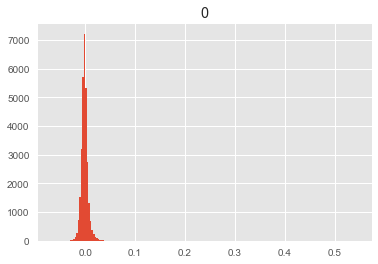

In [22]:
pd.DataFrame(result-result2).hist(bins=200)

In [24]:
X_test.loc[(result-result2)>0.1]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,...,MAP_mul_BMI,MAP_mul_log_BMI,MAP_div_log_BMI,MAP_div_BMI,MAP_mul_MAP,MAP_mul_log_MAP,MAP_div_log_MAP,age_dif,age_dif2,age_dif3
303,1079,22571,2,170,74.0,140,60,1,1,0.0,...,1707.035755,218.741288,15.572251,2.505744,4444.444444,280.972913,12.784633,-38.820557,0.012011,2.046017
2943,9856,18166,1,160,65.0,200,80,1,1,0.0,...,2369.791667,305.480824,21.842532,3.536609,8711.111111,424.371230,16.826414,-79.555170,0.013320,1.825274
13138,43735,23324,2,184,88.0,133,51,3,1,0.0,...,1594.202899,202.127482,14.278320,2.272241,3761.777778,253.459775,11.950000,-14.629133,0.012525,2.222696
28277,94426,21309,1,164,94.0,160,120,1,1,1.0,...,3261.947254,334.330581,20.369058,2.596239,8711.111111,424.371230,16.826414,146.237341,0.021719,3.473596


In [ ]:
# 0.536964010575	0.537253961124 = 0.5430002 less cleaning, more cleaning - 0.5429488

In [ ]:
models = [
#     '+-KERAS_3_hey2',
#     '+-XGB_11.5_hey2',
#     '+-XGB_1.5_hey2',
#     '+-XGB_hist_last_hey2',
#     '+-XGB_5++_hey2',
    'XGB_9_new',
#     '+-XGB_10++_hey2',
#     '+-XGB_15_hey2',
    'XGB_16_hey2',
    'KERAS_3', 'XGB_1_new3+', 'XGB_2hist_new', 'XGB_5+', 'XGB_9_new', 'XGB_10+',  'XGB_12+', 'XGB_13+', 'XGB_14',
          'XGB_11', 'XGB_1_new2', 'XGB_2hist_new', 'XGB_5', 'XGB_9_new', 'XGB_10',
    'KERAS_2_new2',  'XGB_1_new2', 'XGB_2hist_new', 'LGB_1_new',
          'KERAS_2_new2', 'XGB_11', 'XGB_1_new2', 'XGB_2hist_new', 'LGB_1_new', 'XGB_5', 'XGB_9',
         ]
folds = utils.score_by_folds(models, X_train, n_folds=10, stratification_groups=strat)

In [ ]:
r = set()
for i, f in enumerate(folds):
    r.update([a[1] for a in f[:3]])
    print(i, [a[1] for a in f[:3]])

In [ ]:
r